In [0]:
import torch
import numpy as np
import pycocotools.mask as mask_utils
import pylab as plt
from PIL import Image

from torchvision import transforms, models
from torch.autograd import Variable

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import Polygon
from matplotlib.figure import Figure

!mkdir images # please upload the content and style images in the folder /content/images/ in google colab.

import cv2, glob, re
import tqdm
import pandas as pd

import os, sys, re, time

# if you want to import methods that you have created.
sys.path.append('/content/drive/My Drive/MSc_Artificial_Intelligence/Msc Artificial Intelligence/INM705_Deep_Learning_1_Classification/CBStyling-master')
os.chdir('/content/drive/My Drive/MSc_Artificial_Intelligence/Msc Artificial Intelligence/INM705_Deep_Learning_1_Classification/CBStyling-master')

%matplotlib inline

In [0]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

In [0]:
img = Image.open('/content/images/000000000785.jpg')
plt.imshow(img); plt.axis('off'); plt.show()

In [0]:
# Apply the transformations needed
trf = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)
print(inp.shape)

In [0]:
# Pass the input through the net
out = fcn(inp)['out']
print(out.shape)

In [0]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

In [0]:
type(om)

In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(255, 255, 255),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (0, 0, 0),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  # THE SOLUTION TO KEEP THE ORIGINAL PERSON'S COLOURS IS
  # TO USE EITHER INSIDE label_colors[l, inp[RED]] label_colors[l, inp[GREEN]] label_colors[l, inp[BLUE]]

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [0]:
from numpy import asarray
# convert image to numpy array
img_resized = img.resize((224,224), Image.ANTIALIAS)
plt.imshow(img_resized); plt.axis('off'); plt.show()
data = asarray(img_resized)
print(type(data))
# summarize shape
print(data.shape)

data[220,120]

In [0]:
# take the coordinates of the image that include a person
human = []
print(om[200,120])
for g in range(om.shape[0]):
  for h in range(om.shape[1]):
    if om[g,h] == 15:
      human.append([g,h])

In [0]:
print(data[human[0][0], human[0][1]])
len(human)

In [0]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [0]:
import torchvision.transforms as T

def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(1000), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()
  return rgb

In [0]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [0]:
output = segment(dlab, '/content/images/000000000785.jpg')

In [0]:
stylised_img = Image.open('/content/images/Screenshot 2020-05-31 at 06.11.16.png')
plt.imshow(stylised_img); plt.axis('off'); plt.show()

In [0]:
#type(rgb)
#type(data)
#plt.imshow(data); plt.axis('off'); plt.show()

transformation_example = transforms.Compose([transforms.Resize(256),
                 transforms.CenterCrop(224),
                 ])

image_example = transformation_example(stylised_img)
image_np = np.asarray(image_example)

In [0]:
plt.imshow(image_np); plt.axis('off'); plt.show()

for i in range(224):
  for j in range(224):
    if rgb[i,j,0] == 255 and rgb[i,j,1] == 255 and rgb[i,j,2] == 255:
      rgb[i,j] = image_np[i,j]

In [0]:
plt.imshow(rgb); plt.axis('off'); plt.show()

In [0]:
style_dark_background_2 = rgb
for i in range(224):
  for j in range(224):
    if rgb[i, j, 0] != image_np[i, j, 0] and rgb[i, j, 1] != image_np[i, j, 1] and rgb[i, j, 2] != image_np[i, j, 2] :
      style_dark_background_2[i,j] = data[i,j]

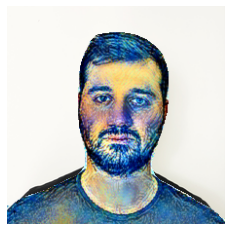

In [0]:
plt.imshow(style_dark_background_2); plt.axis('off'); plt.show()

In [0]:
# DEEPLAB

output_example = transformation_example(output)
output_example.shape
plt.imshow(output); plt.axis('off'); plt.show()

"""
for i in range(224):
  for j in range(224):
    if output[i,j,0] == 255 and output[i,j,1] == 255 and output[i,j,2] == 255:
      output[i,j] = image_np[i,j]

plt.imshow(output); plt.axis('off'); plt.show()

style_white_background_3 = output
for i in range(224):
  for j in range(224):
    if output[i, j, 0] != image_np[i, j, 0] and output[i, j, 1] != image_np[i, j, 1] and output[i, j, 2] != image_np[i, j, 2] :
      style_white_background_3[i,j] = data[i,j]

plt.imshow(style_white_background_3); plt.axis('off'); plt.show()
"""